In [2]:
import torch
device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [3]:
# information
filename = "DAPL_PretrainAE_exp"

In [4]:
import numpy as np
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, random_split
import pandas as pd

def create_mlpEncoder(dimList, activation_func):
    layers = []
    for i in range(len(dimList) - 1):  
        layers.append(nn.Linear(dimList[i], dimList[i + 1]))
        if i < len(dimList) - 2:  
            layers.append(activation_func)

    return nn.Sequential(*layers)

class AE_dense_layers(nn.Module):
    def __init__(self, input_dim, mut_encode_dim, activation_func):
        super(AE_dense_layers, self).__init__()##__init__初始化父類別的屬性和方法
        print('input_dim = ', input_dim)
        print('first_layer_dim = ', mut_encode_dim[0])
        print('second_layer_dim = ', mut_encode_dim[1])

        self.encoder = create_mlpEncoder([input_dim] + mut_encode_dim, activation_func
            )
        self._init_weights(self.encoder)

        self.decoder = create_mlpEncoder(([input_dim] + mut_encode_dim)[::-1], activation_func
            )
        self._init_weights(self.decoder)

    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)

    def forward(self, x):#加self才能呼叫self裡其他的屬性和method
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded


In [39]:
def warmup_lr_scheduler(optimizer, warmup_iters1, Decrease_percent1, warmup_iters2, Decrease_percent2, continuous=True):
    def f(epoch):  
        if epoch < warmup_iters1:
            return 1  # No decrease during first warmup phase
        elif epoch < warmup_iters2:
            if continuous:
                return Decrease_percent1 ** (epoch - warmup_iters1 + 1)
            else:
                return Decrease_percent1
        else:
            if continuous:
                return (Decrease_percent1 ** (warmup_iters2 - warmup_iters1)) * (Decrease_percent2 ** (epoch - warmup_iters2 + 1))
            else:
                return Decrease_percent2
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = warmup_lr_scheduler(optimizer, warmup_iters1=5, Decrease_percent1=10, warmup_iters2=10, Decrease_percent2=0.8, continuous=False)

for epoch in range(20):
    scheduler.step()
    print(f"Epoch {epoch}, LR: {scheduler.get_last_lr()[0]}")

Epoch 0, LR: 0.0001
Epoch 1, LR: 0.0001
Epoch 2, LR: 0.0001
Epoch 3, LR: 0.0001
Epoch 4, LR: 0.001
Epoch 5, LR: 0.001
Epoch 6, LR: 0.001
Epoch 7, LR: 0.001
Epoch 8, LR: 0.001
Epoch 9, LR: 8e-05
Epoch 10, LR: 8e-05
Epoch 11, LR: 8e-05
Epoch 12, LR: 8e-05
Epoch 13, LR: 8e-05
Epoch 14, LR: 8e-05
Epoch 15, LR: 8e-05
Epoch 16, LR: 8e-05
Epoch 17, LR: 8e-05
Epoch 18, LR: 8e-05
Epoch 19, LR: 8e-05


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## def warmup_lr_scheduler

In [40]:
def warmup_lr_scheduler(optimizer, warmup_iters, Decrease_percent,continuous=True):
    def f(epoch):  
        if epoch >= warmup_iters:
            if continuous is True:
                return Decrease_percent ** (epoch-warmup_iters+1)
            elif continuous is not True:
                return Decrease_percent
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

# def warmup_lr_scheduler(optimizer, warmup_iters1, Decrease_percent1, warmup_iters2, Decrease_percent2, continuous=True):
#     def f(epoch):  
#         if epoch < warmup_iters1:
#             return 1  # No decrease during first warmup phase
#         elif epoch < warmup_iters2:
#             if continuous:
#                 return Decrease_percent1 ** (epoch - warmup_iters1 + 1)
#             else:
#                 return Decrease_percent1
#         else:
#             if continuous:
#                 return (Decrease_percent1 ** (warmup_iters2 - warmup_iters1)) * (Decrease_percent2 ** (epoch - warmup_iters2 + 1))
#             else:
#                 return Decrease_percent2
#     return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

import random
# Function to set the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# Set the seed
seed = 42
set_seed(seed)


In [41]:
# load TCGA mutation data, substitute here with other genomics
data_mut_tcga= pd.read_csv("../data/DAPL/share/pretrain_tcga.csv", sep=',', index_col=0)

print("\n\nDatasets successfully loaded.")



Datasets successfully loaded.


In [42]:
data_mut_tcga.shape

(9808, 1426)

In [ ]:
from utils.tools import get_data_value_range
import seaborn as sns
import matplotlib.pyplot as plt
get_data_value_range(data_mut_tcga.values.tolist(),"tcga_EXP", file=None)
sns.kdeplot(np.concatenate(np.array(data_mut_tcga.values.tolist())), fill=True, color='blue')
plt.show()

tcga_EXP : 
Range: 22.04906963
Minimum: -13.71211562
Maximum: 8.33695401
Mean: 0.00000000
Median: 0.01146598
Standard Deviation: 1.00000000
Skewness: -0.02756315
binary data:False
-------------------------------------


NameError: name 'sns' is not defined

In [31]:
# #exchange the row and column to match the format of doctor chiu's data (row is gene ;column is cancer)
# data_mut_tcga=data_mut_tcga.transpose()
# data_mut_tcga.shape

## 也許應該要分train validation set，這樣才能更學到真正重要的特徵，而不是背答案

In [81]:
if __name__ == '__main__':#被別人呼叫的時候不會執行main以下的程式，只會執行

    input_dim = data_mut_tcga.shape[1]# (8238sample[0], 2649gene[1])
    mut_encode_dim =[128,32]
    batch_size = 64
    epoch_size = 500 #100
    activation_function = nn.ReLU()
    model_save_name = "tcga_exp_%d_%d" % (mut_encode_dim[0], mut_encode_dim[1])
    learning_rate=0.001
    warmup_iters = 410
    seed=42
    patience = 25
    Decrease_percent = 0.7
    continuous=True

    torch.manual_seed(seed)
    np.random.seed(seed)
    train_size = int(0.8 * len(data_mut_tcga))
    test_size = len(data_mut_tcga) - train_size
    # Split data into training and testing sets
    train_data, test_data = random_split(data_mut_tcga.values, [train_size, test_size])

    # Create DataLoaders for training and testing
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    t = time.time()
    torch.manual_seed(seed)
    model = AE_dense_layers(input_dim=input_dim, mut_encode_dim=mut_encode_dim, activation_func=activation_function).to(device=device)
    criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    if warmup_iters is not None:
        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters,Decrease_percent,continuous)
        # scheduler = warmup_lr_scheduler(optimizer, warmup_iters1=5, Decrease_percent1=10, warmup_iters2=290, Decrease_percent2=0.8, continuous=False)

    # Training with early stopping (assuming you've defined the EarlyStopping logic)
    
    best_val_loss = float('inf')
    best_weight=None
    counter = 0
    train_epoch_loss_list = []#  for train every epoch loss plot
    test_epoch_loss_list=[]#  for validation every epoch loss plot
    torch.manual_seed(seed)

    for epoch in range(epoch_size):
        model.train()
        model.requires_grad = True
        total_train_loss = 0.0
        for batch_idx,inputs in enumerate(train_loader):
            optimizer.zero_grad()
            inputs =inputs.float().to(device=device) # change torch.Tensor int64 to float32
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() # sum every batch's loss to compute average loss of every batch for one epoch
            #print(f'Epoch {epoch + 1}/{epoch_size} - Batch {batch_idx+1}/{len(dataloader_mut_tcga)} - Loss: {loss.item():.4f}')#batch loss()
        # Calculate and print the average loss of batch for the epoch
        average_loss = total_train_loss / len(train_loader) # 一個 epoch 的 loss 是 batch 的 average loss
        train_epoch_loss_list.append(average_loss)# for loss plot'
        print(f'Epoch {epoch + 1}/{epoch_size} - Train Loss: {average_loss:.8f}')
        
        model.eval()
        model.requires_grad = False
        total_test_loss = 0.0
        
        with torch.no_grad():
            for batch_idx,inputs in enumerate(test_loader):
                inputs =inputs.float().to(device=device) # change torch.Tensor int64 to float32
                outputs = model(inputs)
                test_loss = criterion(outputs, inputs)
                total_test_loss += test_loss.item() 
        test_average_loss = total_test_loss / len(test_loader)
        test_epoch_loss_list.append(test_average_loss)# for loss plot'
        print(f'Epoch {epoch + 1}/{epoch_size} - Test Loss: {test_average_loss:.8f}')

        if warmup_iters:
            print("lr of epoch", epoch + 1, "=>", lr_scheduler.get_lr()) 
            lr_scheduler.step()
        
        if test_average_loss < best_val_loss:
            best_val_loss = test_average_loss
            best_weight = copy.deepcopy(model.state_dict())
            best_epoch = epoch+1
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
                

input_dim =  1426
first_layer_dim =  128
second_layer_dim =  32
Epoch 1/500 - Train Loss: 1.27612219
Epoch 1/500 - Test Loss: 0.90643192
lr of epoch 1 => [0.001]
Epoch 2/500 - Train Loss: 0.76061652
Epoch 2/500 - Test Loss: 0.64880209
lr of epoch 2 => [0.001]
Epoch 4/500 - Train Loss: 0.46102953
Epoch 4/500 - Test Loss: 0.44013021
lr of epoch 4 => [0.001]
Epoch 5/500 - Train Loss: 0.40969900
Epoch 5/500 - Test Loss: 0.40168567
lr of epoch 5 => [0.001]
Epoch 6/500 - Train Loss: 0.37722669
Epoch 6/500 - Test Loss: 0.37320868
lr of epoch 6 => [0.001]
Epoch 7/500 - Train Loss: 0.35379454
Epoch 7/500 - Test Loss: 0.35446100
lr of epoch 7 => [0.001]
Epoch 8/500 - Train Loss: 0.33675984
Epoch 8/500 - Test Loss: 0.33948755
lr of epoch 8 => [0.001]
Epoch 9/500 - Train Loss: 0.32380581
Epoch 9/500 - Test Loss: 0.32781486
lr of epoch 9 => [0.001]
Epoch 10/500 - Train Loss: 0.31348281
Epoch 10/500 - Test Loss: 0.31904828
lr of epoch 10 => [0.001]
Epoch 11/500 - Train Loss: 0.30530168
Epoch 11/500 

In [ ]:
print('batch_size:',batch_size," ",'activation_function:',activation_function," ",
      'learning_rate:',learning_rate," ",'warmup_iters:',warmup_iters)
print("best Epoch : ",best_epoch," ," ,"best_val_loss : ",best_val_loss)
print('\nAutoencoder training completed in %.1f mins.\n' % ((time.time() - t) / 60))

batch_size: 64   activation_function: ReLU()   learning_rate: 0.001   warmup_iters: 410
best Epoch :  429  , best_val_loss :  0.21822737638027437

Autoencoder training completed in 19.1 mins.



In [79]:
encoder_best_weight = {key: value for key, value in best_weight.items() if key.startswith('encoder')} # only store the encoder part without decoder part
torch.save(encoder_best_weight, f'./results/Encoder_{model_save_name}_best_loss_{best_val_loss:.8}.pt')

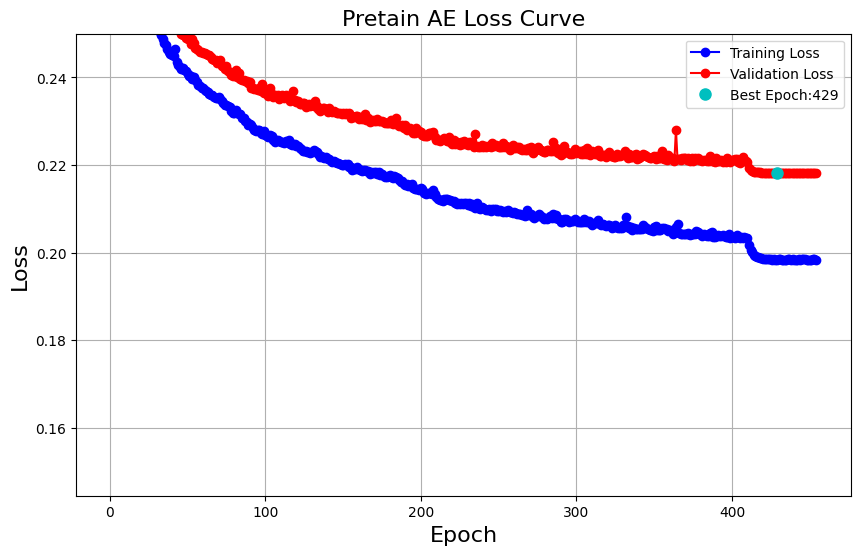

In [80]:
import matplotlib.pyplot as plt
# Create a plot of the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_epoch_loss_list) + 1), train_epoch_loss_list, marker='o', linestyle='-', color='b', label='Training Loss')
# Plot validation loss
plt.plot(range(1, len(test_epoch_loss_list) + 1), test_epoch_loss_list, marker='o', linestyle='-', color='r', label='Validation Loss')
# Mark the best epoch
plt.plot(best_epoch, best_val_loss , marker='o', markersize=8, linestyle='', color='c', label=f'Best Epoch:{best_epoch}')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Pretain AE Loss Curve', fontsize=16)
plt.legend()
plt.grid(True)
plt.ylim(top=0.25)
plt.show()
